In [1]:
from opt.mc_sim import *
import time
from common.variables import *

In [2]:
import pickle as pkl
from opt.eval_policy import *

# filename = "output/msource_value_dic_06-16-2022-09-56-03.pkl"
# filename = "output/msource_value_dic_06-22-2022-03-55-05.pkl"
# filename = "output/msource_value_dic_06-22-2022-20-55-01.pkl"
filename = "output/msource_value_dic_06-23-2022-13-03-05.pkl"

with open(filename, 'rb') as f:
    output_obj = pkl.load(f)

value_dic = output_obj["state_value_dic"]
model_params = output_obj["model_params"]
sourcingEnv = output_obj["mdp_env"]

In [3]:
model_params

{'algo_params': {'prob_epsilon': 1e-08,
  'periods': 29,
  'nested_mc_iters': 20,
  'mc_episodes': 29,
  'max_steps': 29,
  'explore_eps': 0.05,
  'debug_bool': 0,
  'fixed_learn_rate': 0.1},
 'policy_params': {'h_cost': 2,
  'b_penalty': 7,
  'small_s': 2,
  'big_s': 5,
  'n_suppliers': 2,
  'backorder_max': -10,
  'inven_limit': 30},
 'mdp_env_params': {'lambda': 9,
  'max_inven': 30,
  'action_size': 4,
  'discount_fac': 1.0},
 'git_commit': 'no_git',
 'branch_name': 'no_git'}

In [4]:
# best_small_s, best_big_s, best_val = find_opt_ss_policy_via_mc(sourcingEnv, periods = 20, nested_mc_iters = 50)
# best (s, S) policy found by MC:: (2, 5)

In [5]:
# model_params['branch_name'], model_params['git_commit']

In [6]:
# sourcingEnv = SourcingEnv(
#         lambda_arrival = 8, # or 10
#         procurement_cost_vec = np.array([3, 1, 2]),
#         supplier_lead_times_vec = np.array([0.8, 0.5, 1.0]),
#         on_times = np.array([1, 1, 2]), 
#         off_times = np.array([0.3, 1, 0.2]))

# Dual Sourcing
# sourcingEnv = SourcingEnv(
#         lambda_arrival = LAMBDA, # or 10
#         procurement_cost_vec = np.array([3, 1]),
#         supplier_lead_times_vec = np.array([0.8, 0.5]),
#         on_times = np.array([1, 1]), 
#         off_times = np.array([0.3, 1]))

s_custom = MState(stock_level = 0, 
    n_suppliers = N_SUPPLIERS, 
    n_backorders = np.array([0, 0]), 
    flag_on_off = np.array([1, 1]))

mc_avg_costs = mc_with_policy(sourcingEnv, start_state = s_custom, 
    periods = 30,
    nested_mc_iters = 100,
    big_s = model_params['policy_params']['big_s'],
    small_s = model_params['policy_params']['small_s'],
    h_cost = model_params['policy_params']['h_cost'],
    b_penalty = model_params['policy_params']['b_penalty'],
    use_tqdm = True)

# print(mc_avg_costs)

100%|██████████| 100/100 [00:00<00:00, 207.25it/s]


In [7]:
# mc_avg_costs = mc_with_ss_policy(sourcingEnv, 
#     periods = 100,
#     nested_mc_iters = 50,
#     big_s = 5,
#     small_s = 2,
#     h_cost = model_params['policy_params']['h_cost'],
#     b_penalty = model_params['policy_params']['b_penalty'])

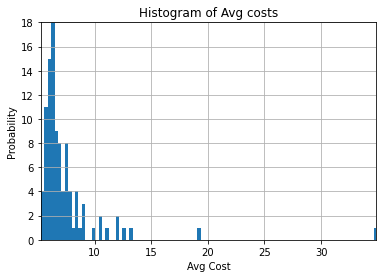

In [8]:
import matplotlib.pyplot as plt
import numpy as np

binwidth = 0.3
n, bins, patches = plt.hist(mc_avg_costs, bins=np.arange( np.min(mc_avg_costs), np.max(mc_avg_costs) + binwidth, binwidth))
# n, bins, patches = plt.hist(mc_avg_costs, density = True)


plt.xlabel('Avg Cost')
plt.ylabel('Probability')
plt.title('Histogram of Avg costs')
plt.xlim(np.min(mc_avg_costs), np.max(mc_avg_costs))
plt.ylim(0, np.max(n))
plt.grid(True)
plt.show()

In [9]:
print(np.mean(np.array(mc_avg_costs)))

7.4446666666666665


In [10]:
print(np.median(np.array(mc_avg_costs)))

6.5


In [11]:
np.std(np.array(mc_avg_costs))

3.403587062040413

In [12]:
sourcingEnv.procurement_cost_vec

array([3, 1])

In [13]:
sourcingEnv2 = SourcingEnv(
    lambda_arrival = LAMBDA, # or 10
    procurement_cost_vec = sourcingEnv.procurement_cost_vec,
    supplier_lead_times_vec = sourcingEnv.supplier_lead_times_vec,
    on_times = sourcingEnv.on_times, 
    off_times = sourcingEnv.off_times)

In [14]:
mc_avg_costs = mc_with_policy(sourcingEnv2, start_state = s_custom, 
    periods = 30,
    nested_mc_iters = 100,
    big_s = model_params['policy_params']['big_s'],
    small_s = model_params['policy_params']['small_s'],
    h_cost = model_params['policy_params']['h_cost'],
    b_penalty = model_params['policy_params']['b_penalty'],
    policy_callback = dual_index_policy,
    use_tqdm = True)

  0%|          | 0/100 [00:00<?, ?it/s]/home/larkin/code/multi-sourcing-inventory/sim/policies.py:72: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  overshoot_range = np.array([x for x in sourcingEnv.action_history_tuple if tmark_reg < x[0] < tmark_exp])
100%|██████████| 100/100 [00:51<00:00,  1.94it/s]


In [15]:
print(np.mean(np.array(mc_avg_costs)))

20.852000000000004


In [16]:
print(np.median(np.array(mc_avg_costs)))

17.816666666666666


In [17]:
np.std(np.array(mc_avg_costs))

10.36842034470268

In [18]:
model_params

{'algo_params': {'prob_epsilon': 1e-08,
  'periods': 29,
  'nested_mc_iters': 20,
  'mc_episodes': 29,
  'max_steps': 29,
  'explore_eps': 0.05,
  'debug_bool': 0,
  'fixed_learn_rate': 0.1},
 'policy_params': {'h_cost': 2,
  'b_penalty': 7,
  'small_s': 2,
  'big_s': 5,
  'n_suppliers': 2,
  'backorder_max': -10,
  'inven_limit': 30},
 'mdp_env_params': {'lambda': 9,
  'max_inven': 30,
  'action_size': 4,
  'discount_fac': 1.0},
 'git_commit': 'no_git',
 'branch_name': 'no_git'}

In [19]:
eval_steps = 10
mc_eval_iter = 10
eval_costs = mc_eval_policy_perf(sourcingEnv, value_dic, 
    max_steps = eval_steps, 
    mc_iters = mc_eval_iter,
    h_cost = model_params['policy_params']['h_cost'],
    b_penalty = model_params['policy_params']['b_penalty'])

avg_eval_cost = np.mean(eval_costs)

100%|██████████| 10/10 [03:40<00:00, 22.06s/it]


In [20]:
eval_costs_scaled = np.array(eval_costs)/eval_steps

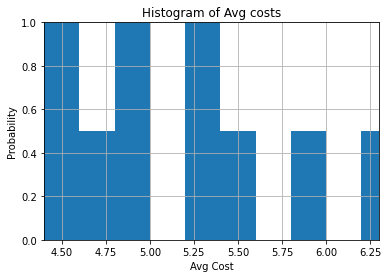

In [21]:
import numpy as np

binwidth = 0.2

n, bins, patches = plt.hist(eval_costs_scaled, bins=np.arange(min(eval_costs_scaled), max(eval_costs_scaled) + binwidth, binwidth), density = True)


plt.xlabel('Avg Cost')
plt.ylabel('Probability')
plt.title('Histogram of Avg costs')
plt.xlim(np.min(eval_costs_scaled), np.max(eval_costs_scaled))
plt.ylim(0, np.max(n))
plt.grid(True)
plt.show()

In [22]:
np.mean(eval_costs_scaled)

5.220000000000001

In [23]:
np.median(eval_costs_scaled)

5.15

In [24]:
np.std(eval_costs_scaled)

0.5861740355901137

In [25]:
len(list(value_dic.keys()))

93394

-5.048275862068965

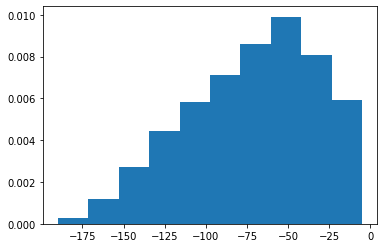

In [26]:
import numpy as np

binwidth = 0.3

state_vals = [x[0] for x in list(value_dic.values())]
state_visits = [x[1] for x in list(value_dic.values())]

n, bins, patches = plt.hist(state_vals, density = True)
np.max(state_vals)

99

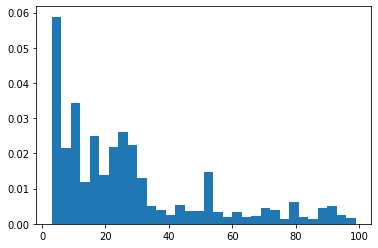

In [27]:
binwidth = 3
state_visits.remove(1)
state_visits_massage = [x for x in state_visits if 100 > x > 2]

n, bins, patches = plt.hist(state_visits_massage, bins=np.arange(min(state_visits_massage), max(state_visits_massage) + binwidth, binwidth), density = True)
np.max(state_visits_massage)

In [28]:
np.min(state_visits_massage)

3

In [29]:
len(set(state_visits))

421

In [30]:
len(state_visits_massage) - len(state_visits)

-43974

In [31]:
len(state_visits)

93393

In [32]:
len(state_vals)

93394

In [33]:

max(value_dic, key=value_dic.get)


'[1, 3, 1, 0, 1]'

In [34]:
min(value_dic, key=value_dic.get)

'[19, 29, 58, 1, 1]'

In [35]:
value_dic_key_sorted = sorted(value_dic, key=value_dic.get, reverse=True)
value_dic_value_sorted = sorted(value_dic.values(), reverse=True)

In [36]:
value_diagnostic = list(zip(value_dic_key_sorted, value_dic_value_sorted))

In [37]:
value_diagnostic

[('[1, 3, 1, 0, 1]', (-5.048275862068965, 7)),
 ('[1, 0, 1, 1, 0]', (-5.215517241379311, 1)),
 ('[0, 0, 2, 1, 1]', (-5.240465517241379, 30)),
 ('[0, 2, 2, 1, 1]', (-5.258346551724138, 68)),
 ('[2, 3, 1, 0, 1]', (-5.275517241379311, 8)),
 ('[0, 1, 1, 0, 1]', (-5.300275862068966, 60)),
 ('[1, 3, 1, 0, 0]', (-5.328793103448276, 58)),
 ('[1, 4, 2, 1, 1]', (-5.3327586206896544, 21)),
 ('[3, 1, 2, 1, 0]', (-5.339655172413794, 6)),
 ('[3, 1, 2, 0, 1]', (-5.343103448275863, 33)),
 ('[1, 0, 2, 1, 0]', (-5.344827586206897, 1)),
 ('[2, 1, 2, 0, 0]', (-5.355172413793104, 28)),
 ('[0, 1, 3, 0, 1]', (-5.3555603448275875, 60)),
 ('[2, 1, 2, 0, 1]', (-5.36503275862069, 62)),
 ('[0, 3, 2, 1, 0]', (-5.366155172413793, 33)),
 ('[0, 2, 4, 0, 1]', (-5.375689655172414, 35)),
 ('[0, 3, 1, 0, 1]', (-5.375689655172414, 33)),
 ('[2, 2, 2, 1, 0]', (-5.387241379310346, 11)),
 ('[0, 2, 0, 0, 1]', (-5.402256896551725, 32)),
 ('[1, 2, 2, 0, 1]', (-5.431034482758621, 7)),
 ('[1, 0, 3, 1, 1]', (-5.454877570689655, 119

In [38]:
with open('output/diagnostic_output.txt', 'w') as f:
    for item in value_diagnostic:
        f.write("{i}\n".format(i = str(item)) )

In [39]:
item

('[19, 29, 58, 1, 1]', (-189.9448275862069, 1))

In [40]:
len(value_dic)

93394